In [28]:
import torch
from scripts import dog_breed
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import os
from torchvision.datasets import ImageFolder
import shutil
%matplotlib inline

#### Train dataset curation

In [73]:
specified_breeds = [
    'chihuahua', 'doberman', 'english_setter',
    'German_shepherd', 'golden_retriever', 'great_dane', 'pug',
    'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier'
]

source_folder = 'stanford_dogs/images/Images/'
target_folder = 'filtered_dataset/train'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [74]:
dataset = ImageFolder('filtered_dataset/train/')

In [75]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(1037, 115, 493)

In [76]:
breeds = []

def rename(name):
    return name.split('-', 1)[-1].lower()

for n in dataset.classes:
    breeds.append(rename(n))

In [77]:
breeds

['chihuahua',
 'doberman',
 'english_setter',
 'golden_retriever',
 'great_dane',
 'pug',
 'siberian_husky',
 'toy_poodle',
 'west_highland_white_terrier',
 'yorkshire_terrier']

In [78]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(1037, 115, 493)

In [79]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=300x421>, 1)

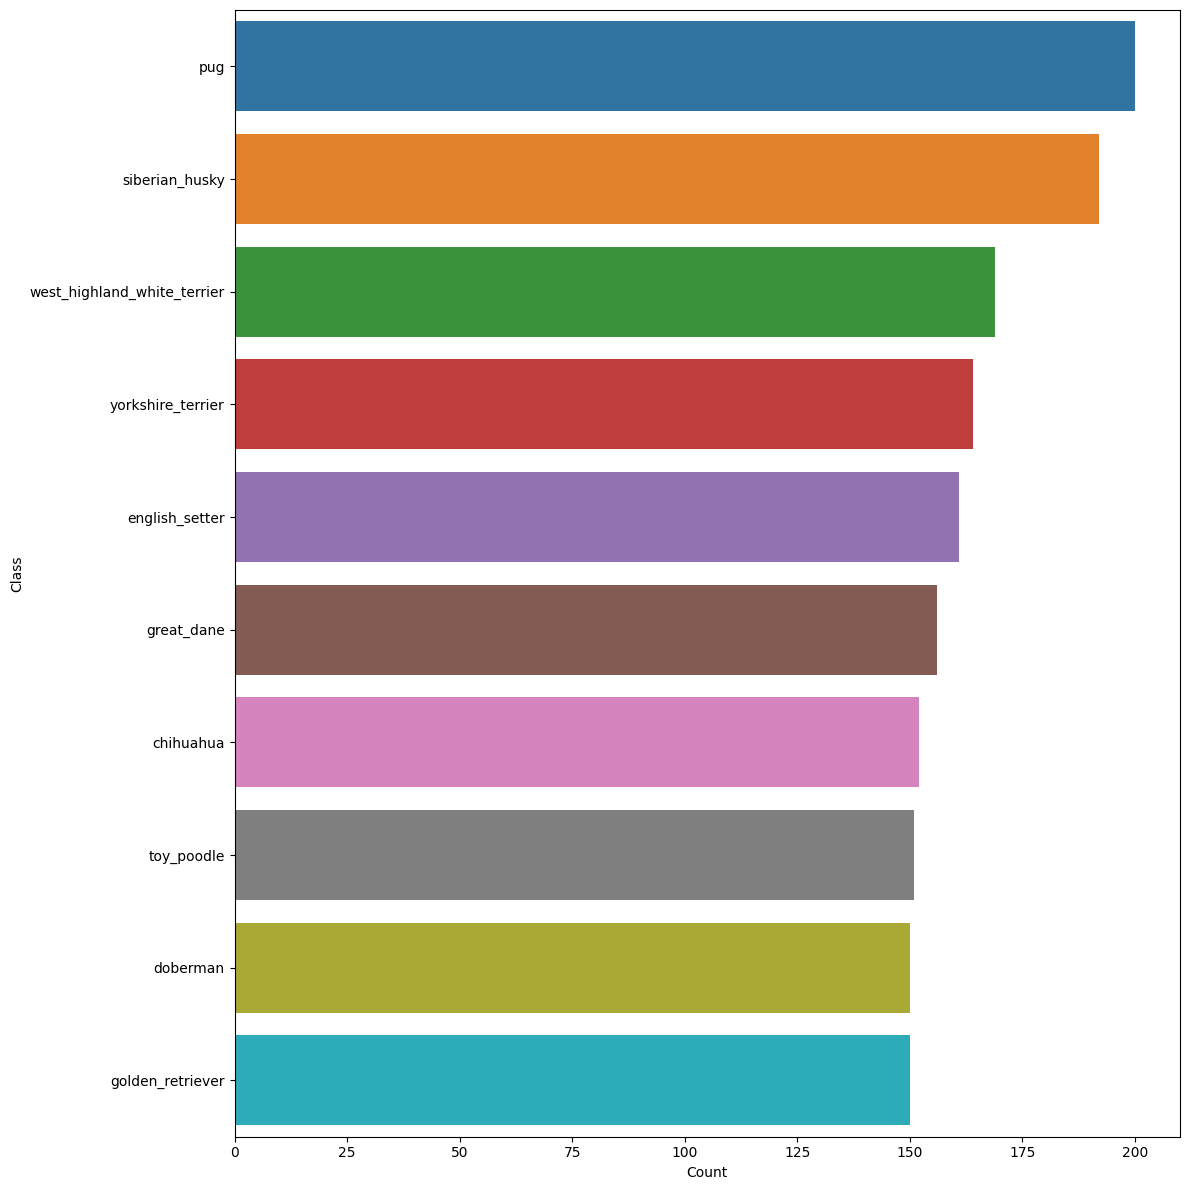

In [81]:
class_names = breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 12), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

##### DataLoader

In [82]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [83]:
train_dataset = dog_breed.DogBreedDataset(train_ds, train_transform)
val_dataset = dog_breed.DogBreedDataset(val_ds, val_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds, test_transform)

batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size*2)
test_dl = DataLoader(test_dataset, batch_size*2)

7


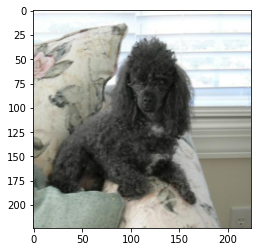

In [84]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

##### Train loop

In [85]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(breeds)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 15
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    dog_breed.train_one_epoch(model, train_dl, criterion, optimizer, device)
    dog_breed.test_model(model, test_dl, criterion, device)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15


100%|██████████| 65/65 [00:03<00:00, 17.02it/s]


Train Loss: 1.3674 Acc: 0.6249
Test Loss: 0.6319 Acc: 0.9189
Epoch 2/15


100%|██████████| 65/65 [00:03<00:00, 16.39it/s]


Train Loss: 0.5736 Acc: 0.8727
Test Loss: 0.3984 Acc: 0.9148
Epoch 3/15


100%|██████████| 65/65 [00:03<00:00, 17.78it/s]


Train Loss: 0.3947 Acc: 0.9074
Test Loss: 0.2983 Acc: 0.9331
Epoch 4/15


100%|██████████| 65/65 [00:03<00:00, 18.17it/s]


Train Loss: 0.3256 Acc: 0.9257
Test Loss: 0.2874 Acc: 0.9249
Epoch 5/15


100%|██████████| 65/65 [00:03<00:00, 17.16it/s]


Train Loss: 0.2696 Acc: 0.9306
Test Loss: 0.2783 Acc: 0.9229
Epoch 6/15


100%|██████████| 65/65 [00:03<00:00, 16.62it/s]


Train Loss: 0.2315 Acc: 0.9441
Test Loss: 0.2250 Acc: 0.9574
Epoch 7/15


100%|██████████| 65/65 [00:03<00:00, 18.04it/s]


Train Loss: 0.1952 Acc: 0.9537
Test Loss: 0.2245 Acc: 0.9391
Epoch 8/15


100%|██████████| 65/65 [00:03<00:00, 17.47it/s]


Train Loss: 0.1790 Acc: 0.9508
Test Loss: 0.2149 Acc: 0.9371
Epoch 9/15


100%|██████████| 65/65 [00:03<00:00, 18.36it/s]


Train Loss: 0.1791 Acc: 0.9537
Test Loss: 0.2234 Acc: 0.9351
Epoch 10/15


100%|██████████| 65/65 [00:03<00:00, 17.78it/s]


Train Loss: 0.1526 Acc: 0.9643
Test Loss: 0.2029 Acc: 0.9533
Epoch 11/15


100%|██████████| 65/65 [00:03<00:00, 17.85it/s]


Train Loss: 0.1529 Acc: 0.9585
Test Loss: 0.2216 Acc: 0.9371
Epoch 12/15


100%|██████████| 65/65 [00:03<00:00, 17.81it/s]


Train Loss: 0.1473 Acc: 0.9566
Test Loss: 0.2182 Acc: 0.9412
Epoch 13/15


100%|██████████| 65/65 [00:03<00:00, 18.34it/s]


Train Loss: 0.1461 Acc: 0.9605
Test Loss: 0.2224 Acc: 0.9331
Epoch 14/15


100%|██████████| 65/65 [00:03<00:00, 18.07it/s]


Train Loss: 0.1222 Acc: 0.9691
Test Loss: 0.2170 Acc: 0.9331
Epoch 15/15


100%|██████████| 65/65 [00:03<00:00, 17.68it/s]


Train Loss: 0.1036 Acc: 0.9769
Test Loss: 0.2237 Acc: 0.9371


#### Test on scrapped dataset

In [105]:
specified_breeds = [
    'chihuahua', 'doberman', 'english_setter',
    'German_shepherd', 'golden_retriever', 'great_dane', 'pug',
    'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier'
]

source_folder = 'breed_dataset/dog/'
target_folder = 'filtered_dataset/test'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [106]:
test_data_scrap = ImageFolder('filtered_dataset/test/')

In [107]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

batch_size = 16
test_dataset_scrap = dog_breed.DogBreedDataset(test_data_scrap, test_transform)
test_dl_scrap = DataLoader(test_dataset, batch_size*2)

In [109]:
dog_breed.test_model(model, test_dl_scrap, criterion, device)

Test Loss: 0.2237 Acc: 0.9371
